# Load Ground Truth Datasets:

In [12]:
# Load csv file and print the first 5 rows
import pandas as pd

amath_ground_truth = pd.read_csv('test/amath_qns_eval_testdata.csv')
print(amath_ground_truth.head())

emath_ground_truth = pd.read_csv('test/emath_qns_eval_testdata.csv')
print(emath_ground_truth.head())

                                       question_type  \
0                   Applications of binomial theorem   
1                   Application of tangent in circle   
2                       Problem on maxima and minima   
3    Graphs of exponential and logarithmic functions   
4  Finding equation of circle and determining if ...   

                                            question  \
0  Could you provide me with practice problems on...   
1  Can you provide practice problems on the appli...   
2  Can you provide practice problems on maxima an...   
3  Can you provide practice problems on graphs of...   
4  Could you give me some practice questions on c...   

                                     valid_documents  
0  '674dcd3ab00b977d048c92e0'; '674dcd15b00b977d0...  
1  '674dcd41b00b977d048c92ed'; '674dcd43b00b977d0...  
2  '674dcd25b00b977d048c92c9'; '674dcd40b00b977d0...  
3  '674dcd17b00b977d048c92bb'; '674dcd2ab00b977d0...  
4  '674dcd34b00b977d048c92dc'; '674dcd10b00b977d0..

# Define Query Evaluation

In [13]:
# For a user query, we use the vector_search function to find the most similar docs in our database
# We then evaluate the retrieval performance with the ground truth docs in our dataset
from app.utils.retrieveal_eval_utils import evaluate_retrieval
from app.db.vector_search import vector_search

import os
from typing import List, Optional
import openai
from pydantic import BaseModel
from pymongo.collection import Collection
from dotenv import load_dotenv
from pymongo import MongoClient

load_dotenv()
openai.api_key = os.environ.get("OPENAI_API_KEY")
mongo_client = MongoClient(os.environ.get("MONGODB_URI"))
db = mongo_client["exam_db"]
collection = db["question"]

def evaluate_query(query: str, ground_truth_docs: str, numCandidates: int, returnLimit: int, mql: bool, subject: str= "additional_mathematics", debug: Optional[bool]=False):
    '''
    Outputs the evaluation metrics for a given query:
    Dictionary containing the following keys:
    - "precision": precision score
    - "recall": recall score
    - "f1": F1 score
    - "jaccard": Jaccard score
    - "mean_avg_prec": Mean Average Precision score
    - "mrr": Mean Reciprocal Rank score
    - "doc_ids": list of document IDs in the intersection of the ground truth and predictions
    '''
    query_variables = [subject, "", ""]
    results = vector_search(
                    user_query=query,
                    collection=collection,
                    query_variables=query_variables,
                    numCandidates=numCandidates,
                    returnLimit=returnLimit,
                    mql=mql)
    ground_truth = [docID.strip()[1:-1] for docID in ground_truth_docs.split(";")]
    results = [str(result["_id"]) for result in results]
    results_dict = evaluate_retrieval(ground_truth, results)
    if debug:
        print("Query:", query)
        print("Ground Truth:", ground_truth)
        print("Results:", results)
        print("Results Dict:", results_dict)
    return results_dict

# Define function that loops through all the queries in a ground_truth dataset

In [14]:
# Loop through the ground truth data and evaluate the retrieval performance for each query

def evaluate_ground_truth(subject: str, mql: bool, numCandidates: int, returnLimit: int, debug: Optional[bool]=False):
    '''
    Outputs the average of evaluation metrics for the entire ground truth dataset
    '''
    if subject == "additional_mathematics":
        ground_truth = amath_ground_truth
    elif subject == "elementary_mathematics":
        ground_truth = emath_ground_truth
    else:
        raise ValueError("Invalid subject")
    
    # Keep track of the evaluation metrics for the entire dataset
    total_queries = len(ground_truth)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_jaccard = 0
    total_mean_avg_prec = 0
    total_mrr = 0
    
    for index, row in ground_truth.iterrows():
        query = row["question"]
        ground_truth_docs = row["valid_documents"]
        # print(f"Query: {query}")
        # print(f"Ground truth: {ground_truth_docs}")
        results_dict = evaluate_query(query=query,
                                      ground_truth_docs=ground_truth_docs, 
                                      numCandidates=numCandidates, 
                                      returnLimit=returnLimit,
                                      mql=mql, 
                                      subject=subject, 
                                      debug=debug)
        # print(f"Query: {query}")
        # print(f"Ground truth: {ground_truth_docs}")
        # print(f"Results: {results_dict}")
        # print("\n")
        total_precision += results_dict["precision"]
        total_recall += results_dict["recall"]
        total_f1 += results_dict["f1"]
        total_jaccard += results_dict["jaccard"]
        total_mean_avg_prec += results_dict["mean_avg_prec"]
        total_mrr += results_dict["mrr"]
        
    avg_precision = total_precision / total_queries
    avg_recall = total_recall / total_queries
    avg_f1 = total_f1 / total_queries
    avg_jaccard = total_jaccard / total_queries
    avg_mean_avg_prec = total_mean_avg_prec / total_queries
    avg_mrr = total_mrr / total_queries
    
    evaluation_metrics = {
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "jaccard": avg_jaccard,
        "mean_avg_prec": avg_mean_avg_prec,
        "mrr": avg_mrr
    }
    return evaluation_metrics

# Define Grid Search parameters:

Do one run through for non-prefiltering, and another for prefiltering

In [23]:
# Define Grid Search Parameters: numCandidates, returnLimit
# mqls = [True, False]
# returnLimits = [1,2, 3, 4, 5, 10, 15, 20]
returnLimits = [15]
numCandidates = [20,30,40,50,60]

# Iterate over Grid Search parameters

In [24]:
# Define the list of subjects
subjects = ['additional_mathematics', 'elementary_mathematics']

# Initialize an empty list to store the results
results = []

# Perform grid search over numCandidates and returnLimit
# for mql in mqls:
for retLim in returnLimits:
    for num in numCandidates:
        for subj in subjects:
            # Evaluate the ground truth and get evaluation metrics
            print(f"Evaluating {subj}, numCandidates: {num}, returnLimit: {retLim}...")
            metrics = evaluate_ground_truth(
                subject=subj,
                mql = mql,
                numCandidates=num,
                returnLimit=retLim, 
                debug=False)
            # Store the parameters and metrics
            result = {
                'subject': subj,
                'mql': mql,
                'numCandidates': num,
                'returnLimit': retLim,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'jaccard': metrics['jaccard'],
                'mean_avg_prec': metrics['mean_avg_prec'],
                'mrr': metrics['mrr']
            }
            print(f"Evaluation metrics for {subj}, numCandidates: {num}, returnLimit: {retLim}: \n {result}\n\n")
            results.append(result)
                
# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results)

Evaluating additional_mathematics, numCandidates: 20, returnLimit: 15...
Evaluation metrics for additional_mathematics, numCandidates: 20, returnLimit: 15: 
 {'subject': 'additional_mathematics', 'mql': False, 'numCandidates': 20, 'returnLimit': 15, 'precision': 0.17333333333333334, 'recall': 0.64, 'f1': 0.27087719298245616, 'jaccard': 0.15764705882352942, 'mean_avg_prec': 0.3645843045843046, 'mrr': 0.7}


Evaluating elementary_mathematics, numCandidates: 20, returnLimit: 15...
Evaluation metrics for elementary_mathematics, numCandidates: 20, returnLimit: 15: 
 {'subject': 'elementary_mathematics', 'mql': False, 'numCandidates': 20, 'returnLimit': 15, 'precision': 0.17142857142857143, 'recall': 0.5321428571428571, 'f1': 0.2535546941888884, 'jaccard': 0.15536881419234358, 'mean_avg_prec': 0.357596669203812, 'mrr': 0.5238095238095238}


Evaluating additional_mathematics, numCandidates: 30, returnLimit: 15...
Evaluation metrics for additional_mathematics, numCandidates: 30, returnLimit: 1

In [25]:
print(results_df.columns)

Index(['subject', 'mql', 'numCandidates', 'returnLimit', 'precision', 'recall',
       'f1', 'jaccard', 'mean_avg_prec', 'mrr'],
      dtype='object')


In [26]:
results_df.to_csv('test/grid_search_results/(TEST_DATA)grid_search_over_numCandidates_results.csv', index=False)

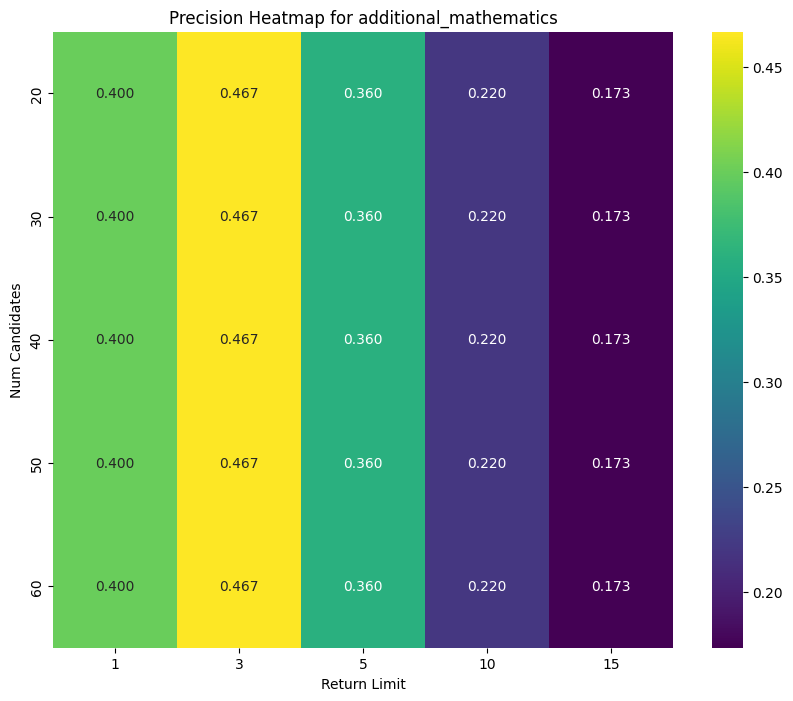

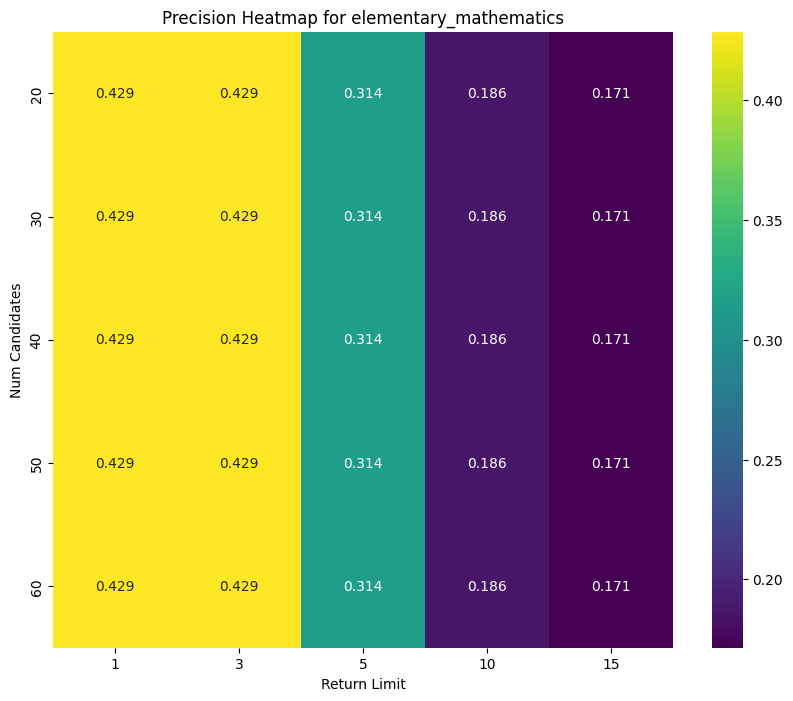

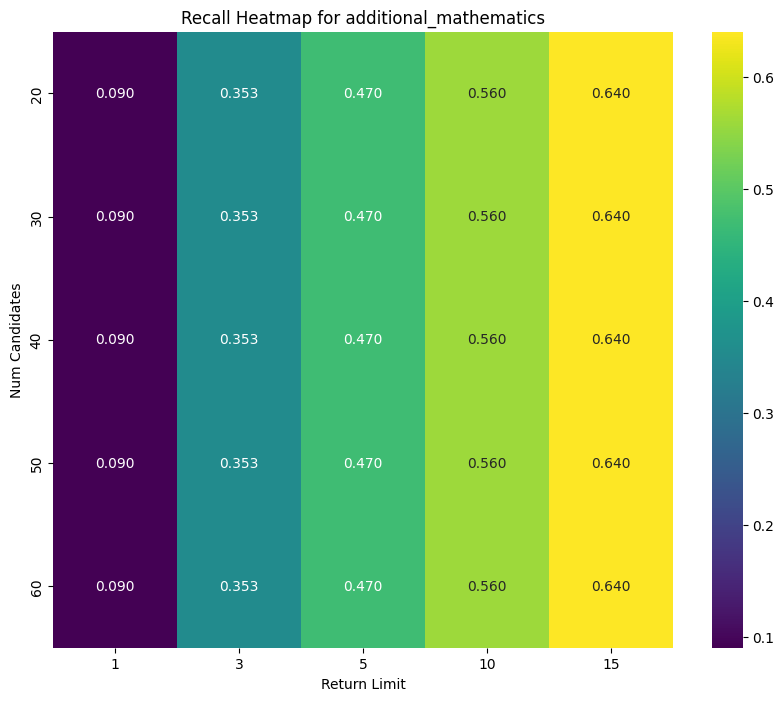

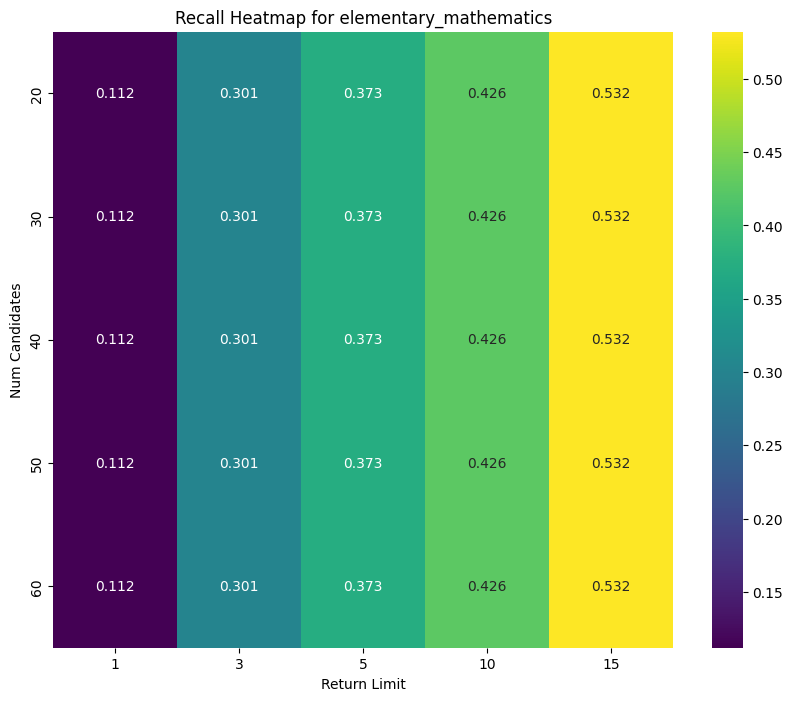

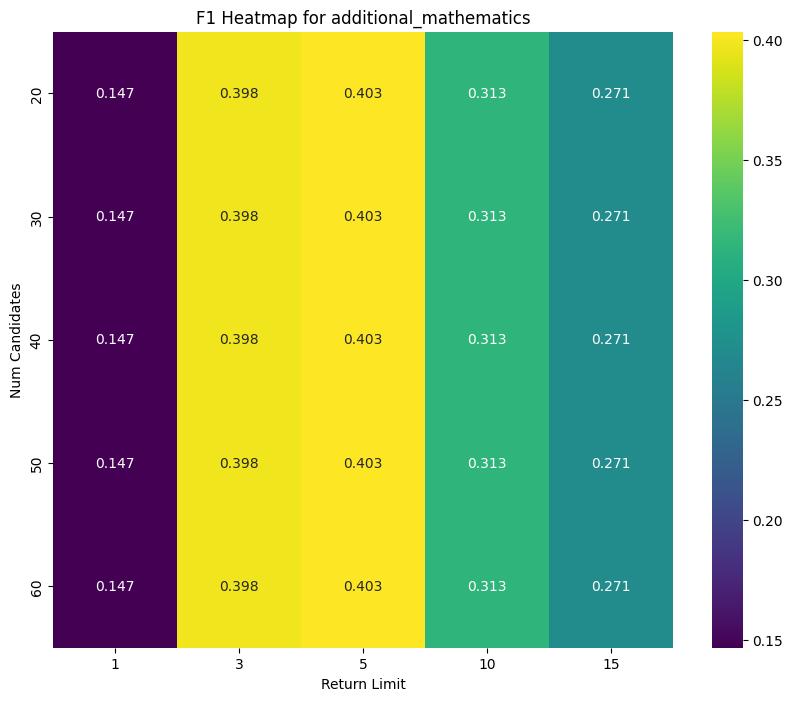

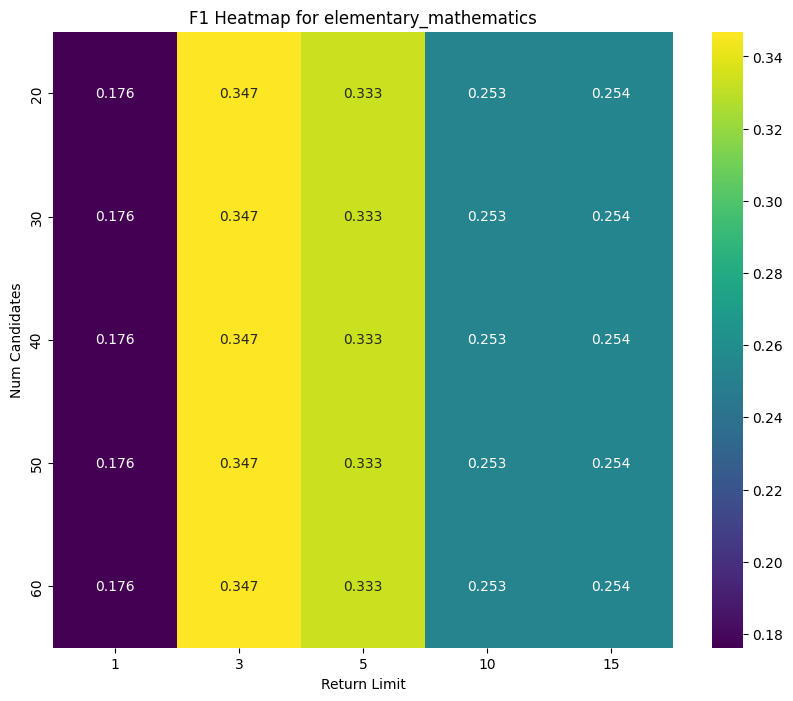

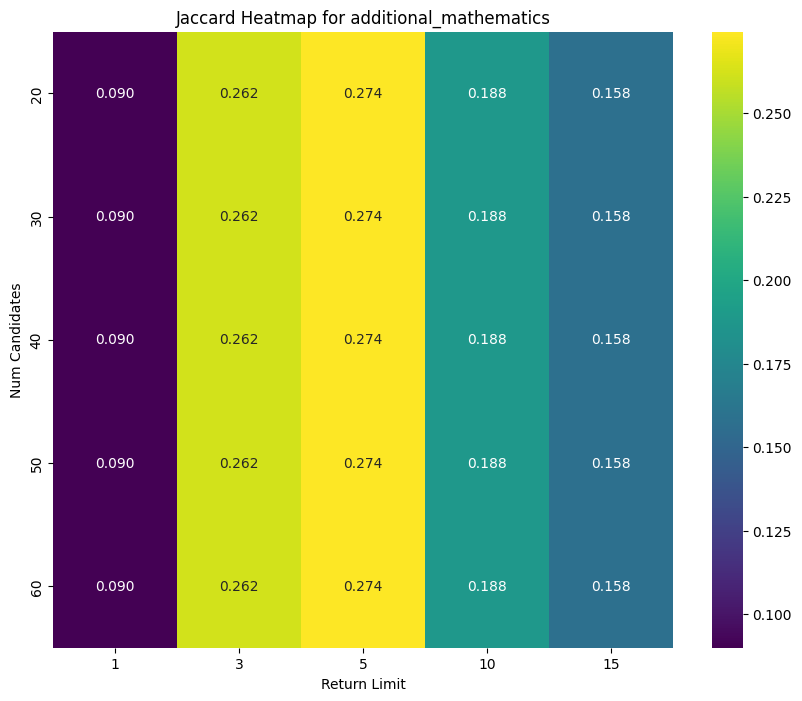

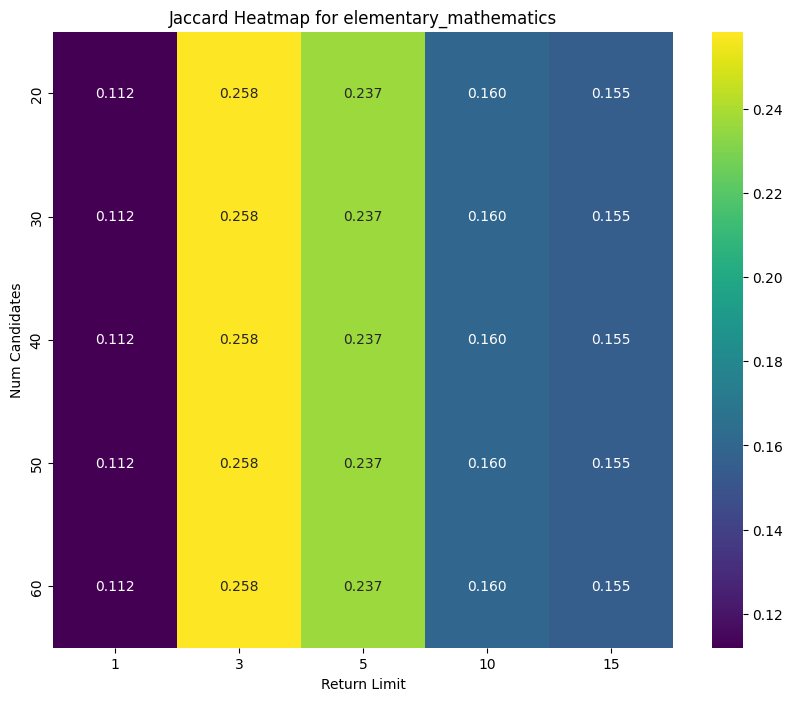

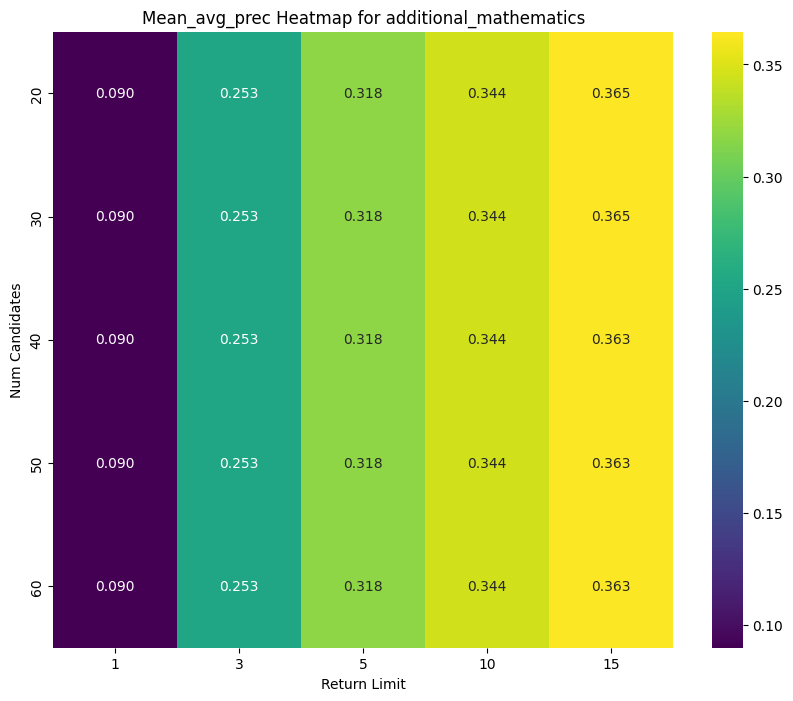

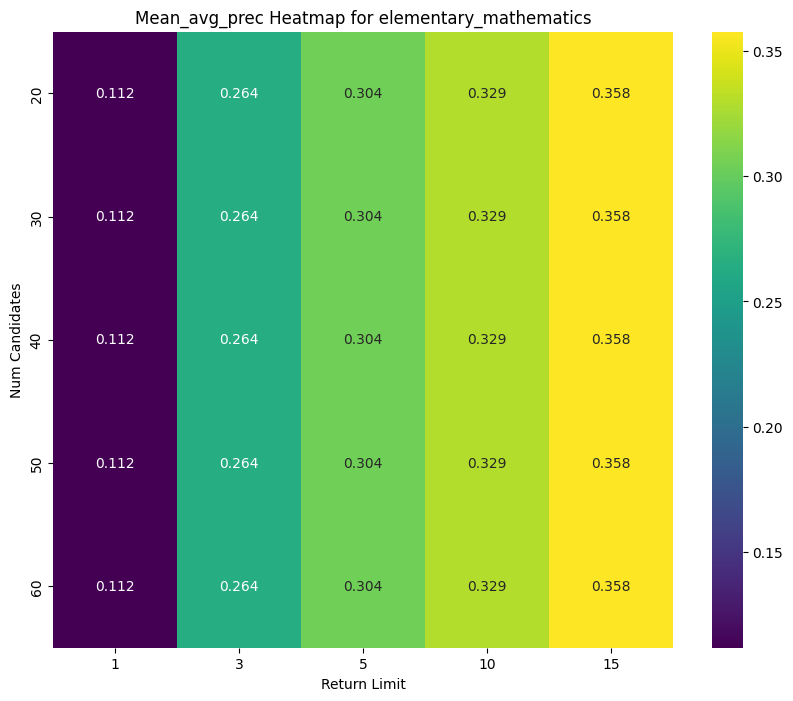

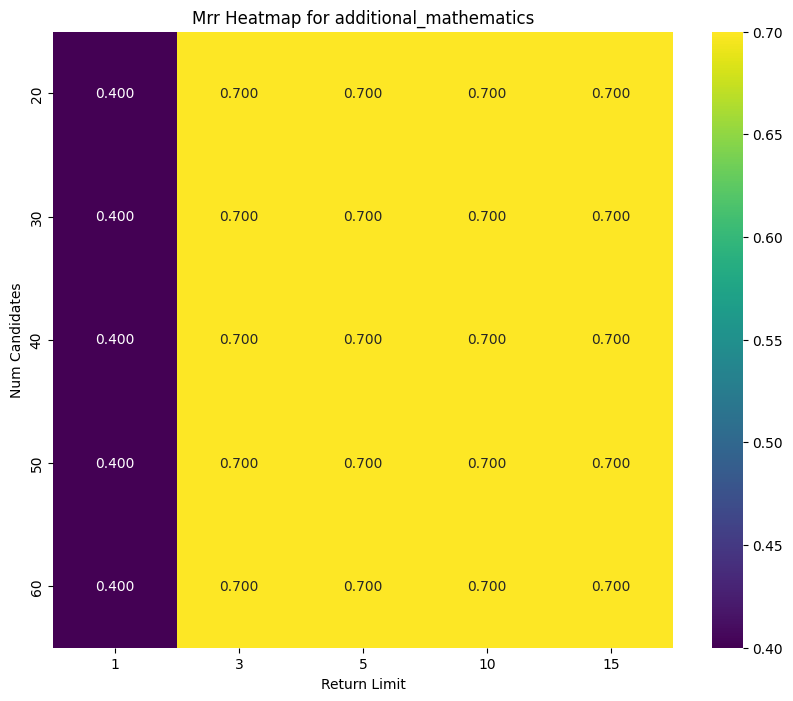

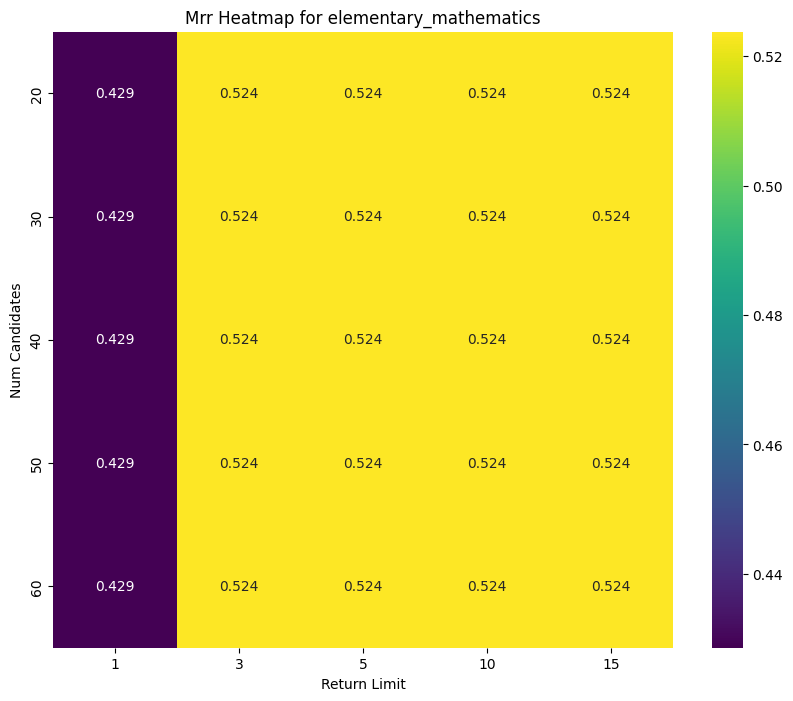

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics_list = ['precision', 'recall', 'f1', 'jaccard', 'mean_avg_prec', 'mrr']
for metric in metrics_list:
    # Plotting for each subject
    for subj in subjects:
        subj_data = results_df[results_df['subject'] == subj]
        pivot_table = subj_data.pivot_table(values=metric, index='numCandidates', columns='returnLimit', aggfunc='mean')
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap='viridis')
        plt.title(f'{metric.capitalize()} Heatmap for {subj}')
        plt.xlabel('Return Limit')
        plt.ylabel('Num Candidates')
        
        plt.savefig(f'evaluation_plots/TESTDATA_numCandidates_returnLimit_{metric}heatmap.png')
        plt.show()

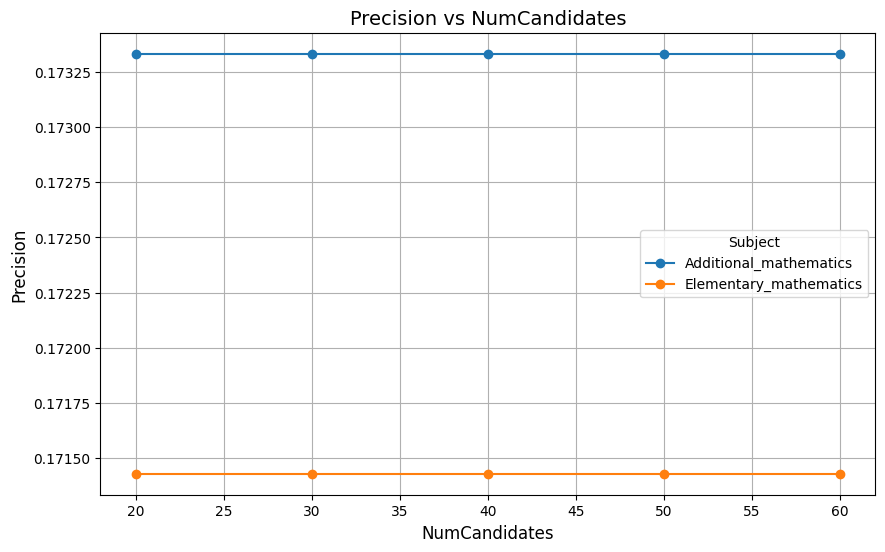

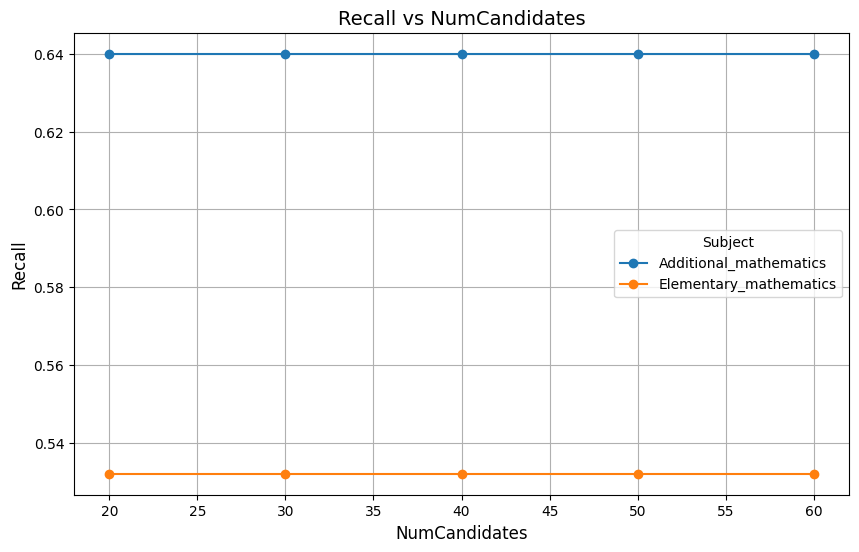

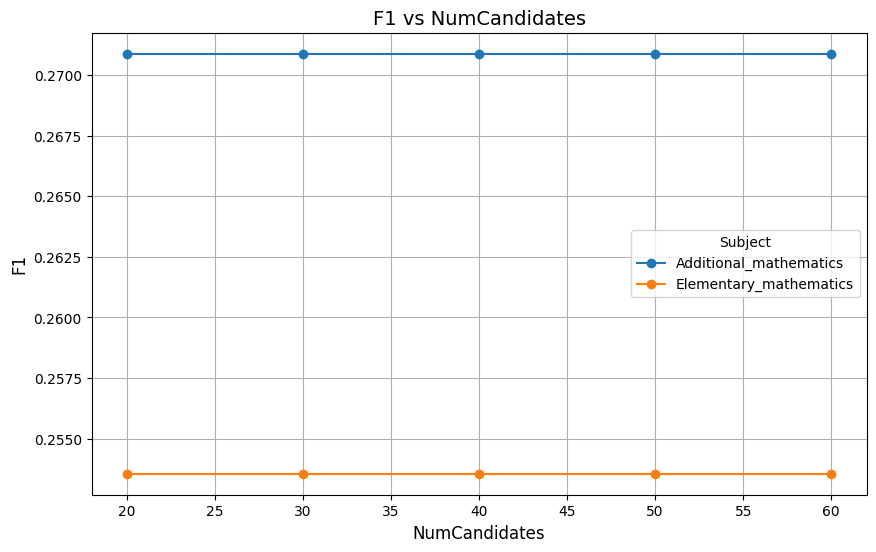

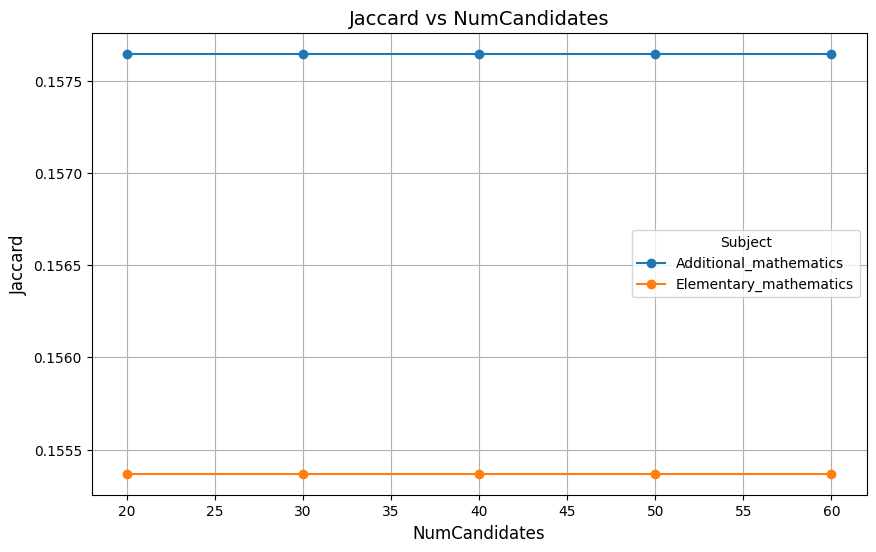

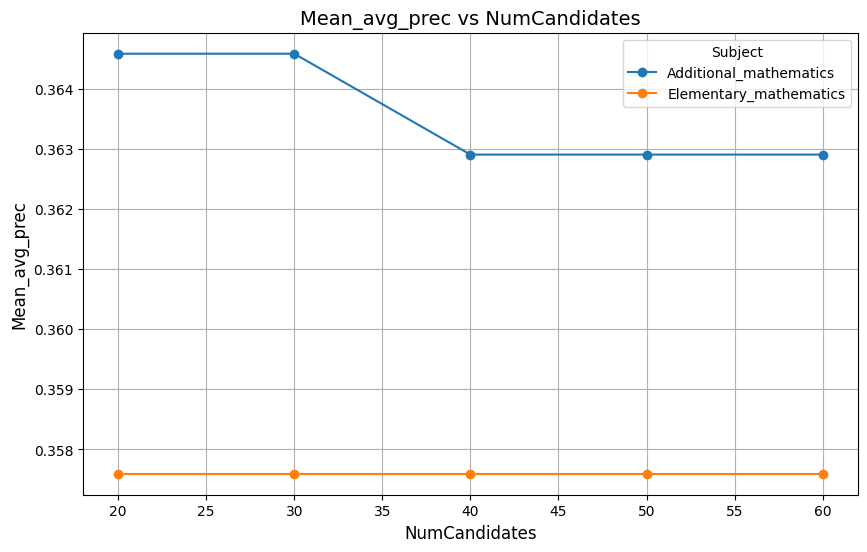

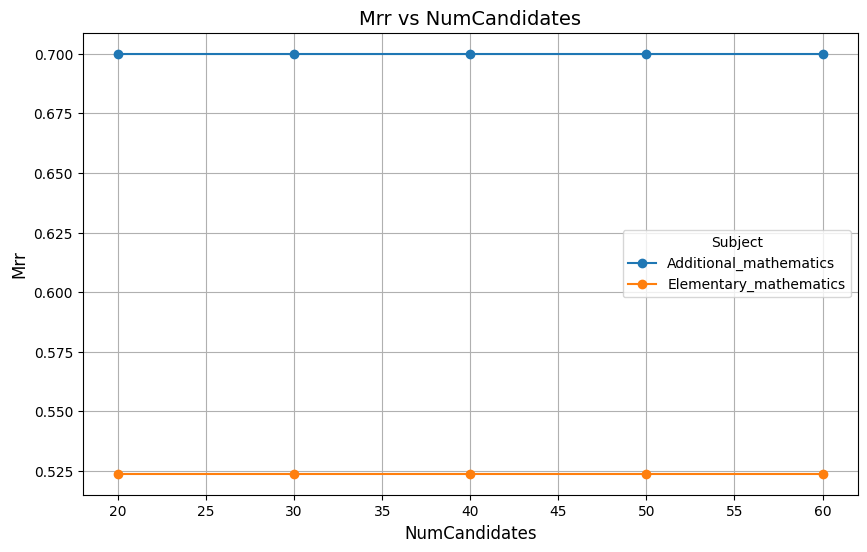

In [28]:
import matplotlib.pyplot as plt

# Now, plot line graphs for every evaluation metric
metrics_list = ['precision', 'recall', 'f1', 'jaccard', 'mean_avg_prec', 'mrr']

for metric in metrics_list:
    plt.figure(figsize=(10, 6))
    
    for subj in subjects:
        # Filter data for the current subject
        subj_data = results_df[results_df['subject'] == subj]
        
        # Sort data by numCandidates to ensure proper line plotting
        subj_data = subj_data.sort_values(by='numCandidates')
        
        # Plot the line for the current subject
        plt.plot(
            subj_data['numCandidates'],
            subj_data[metric],
            marker='o',
            label=f"{subj.capitalize()}",
        )
    
    # Add titles and labels
    plt.title(f'{metric.capitalize()} vs NumCandidates', fontsize=14)
    plt.xlabel('NumCandidates', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title="Subject", fontsize=10)
    plt.grid(True)
    
    plt.savefig(f'evaluation_plots/TESTDATA_numCandidates_{metric}_line.png')
    plt.show()


/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = subj_data['returnLimit'].replace('mql', -1)
/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])


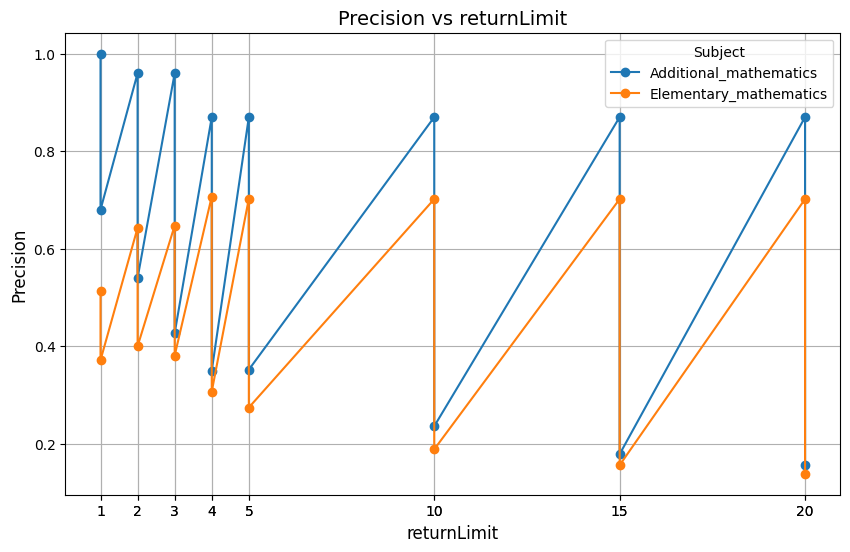

/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = subj_data['returnLimit'].replace('mql', -1)
/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])


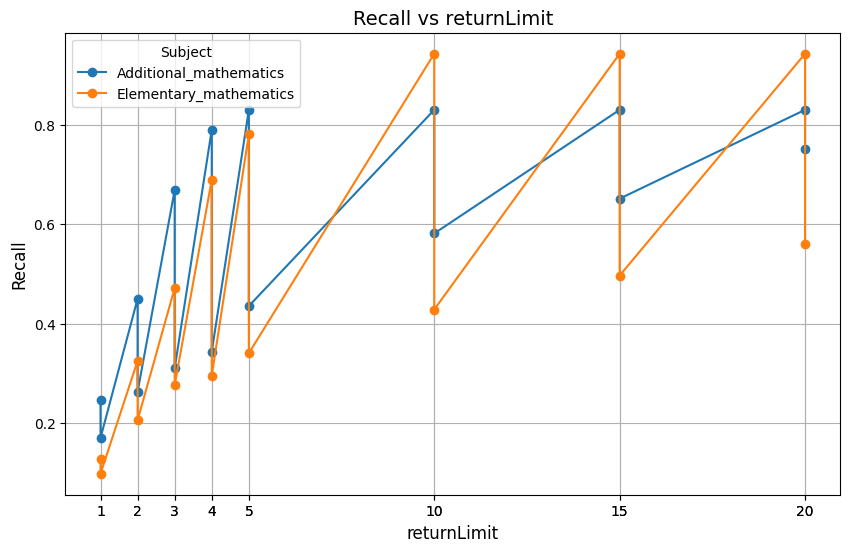

/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = subj_data['returnLimit'].replace('mql', -1)
/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])


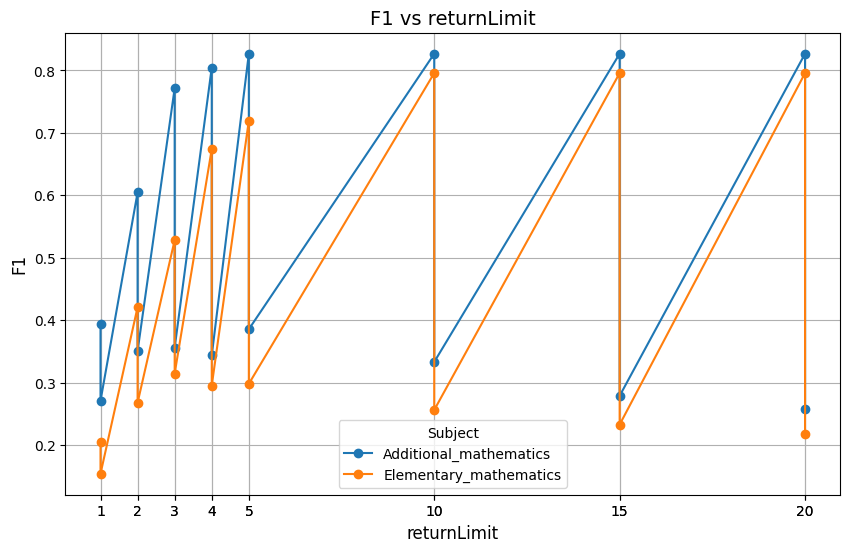

/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = subj_data['returnLimit'].replace('mql', -1)
/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])


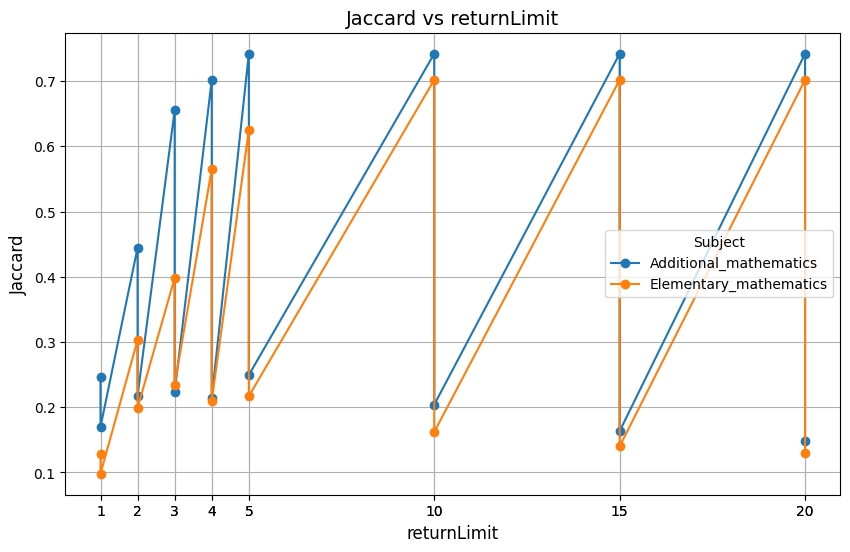

/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = subj_data['returnLimit'].replace('mql', -1)
/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])


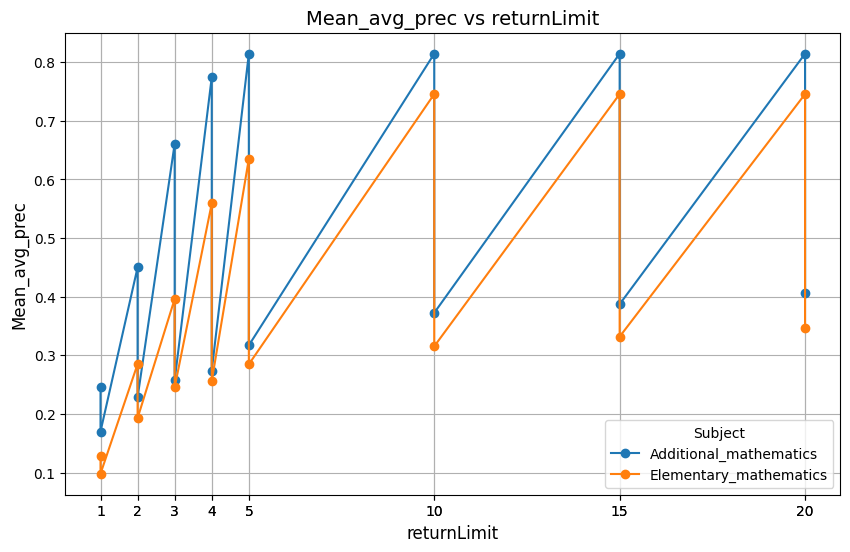

/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = subj_data['returnLimit'].replace('mql', -1)
/var/folders/__/sxrs_frj41bdj4fb9smfcr9m0000gn/T/ipykernel_34377/1392568071.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])


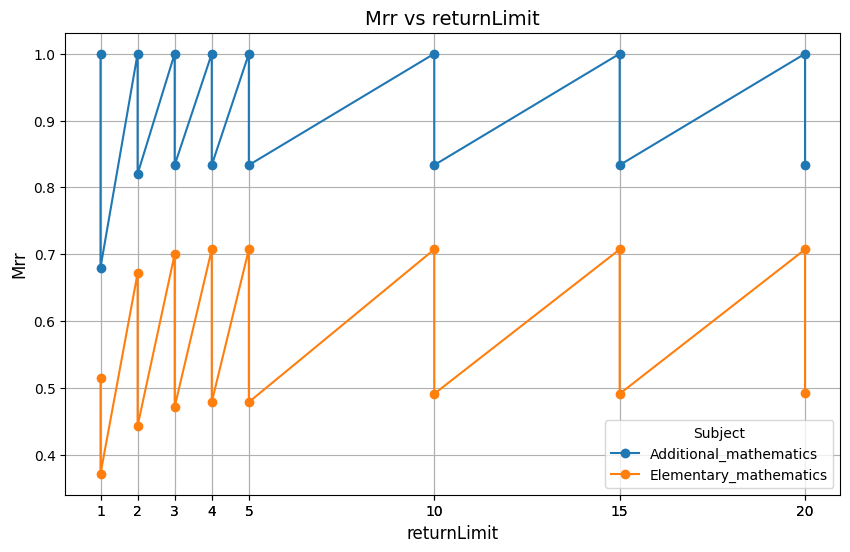

In [10]:
import matplotlib.pyplot as plt

# Plot line graphs for every evaluation metric, with one plot per metric
metrics_list = ['precision', 'recall', 'f1', 'jaccard', 'mean_avg_prec', 'mrr']

for metric in metrics_list:
    plt.figure(figsize=(10, 6))
    
    for subj in subjects:
        # Filter data for the current subject
        subj_data = results_df[results_df['subject'] == subj]
        
        # Sort data by numCandidates to ensure proper line plotting
        # Convert 'returnLimit' to numeric
        subj_data['returnLimit'] = pd.to_numeric(subj_data['returnLimit'])

        # Sort values
        subj_data = subj_data.sort_values(by='returnLimit')
        
        # Plot the line for the current subject
        plt.plot(
            subj_data['returnLimit'],
            subj_data[metric],
            marker='o',
            label=f"{subj.capitalize()}"
        )
    
    # Add titles and labels
    plt.title(f'{metric.capitalize()} vs returnLimit', fontsize=14)
    plt.xlabel('returnLimit', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title="Subject", fontsize=10)
    plt.grid(True)
    # Save the plot
    plt.savefig(f'evaluation_plots/ALLDATA_by_subject_returnLimit{metric}_{subj}.png')
    
    plt.show()

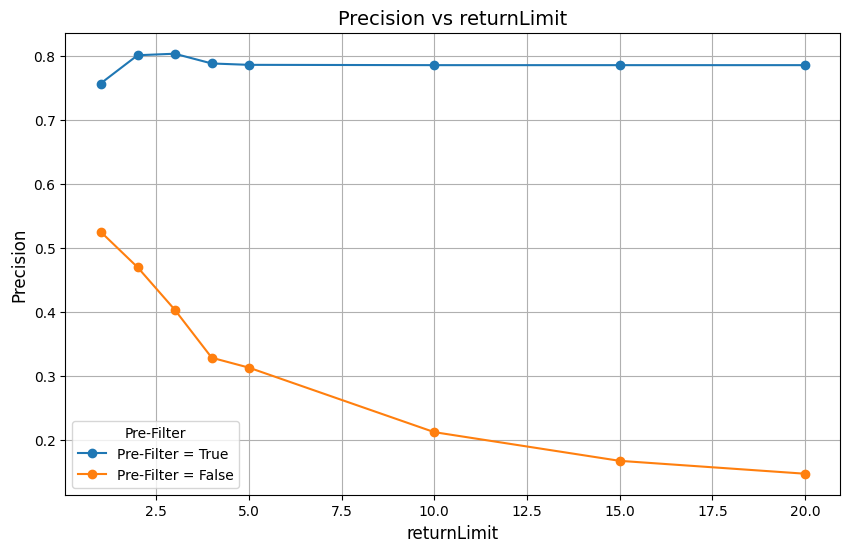

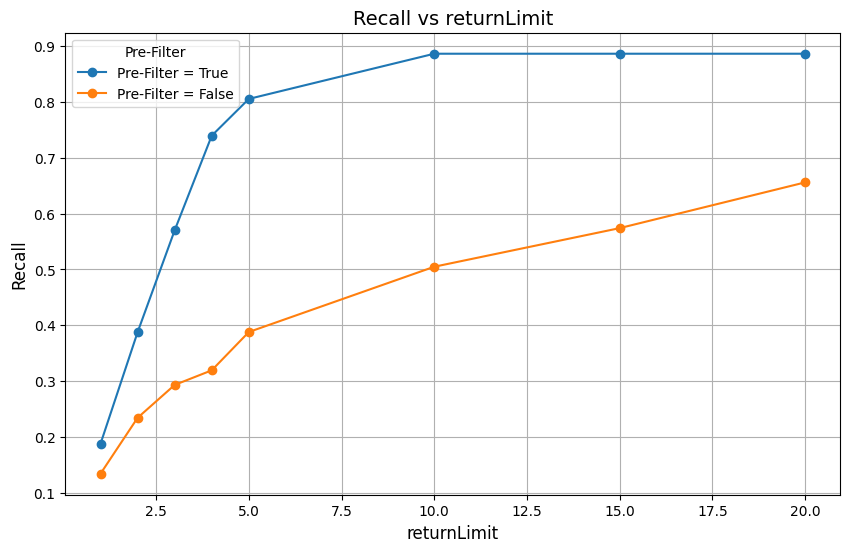

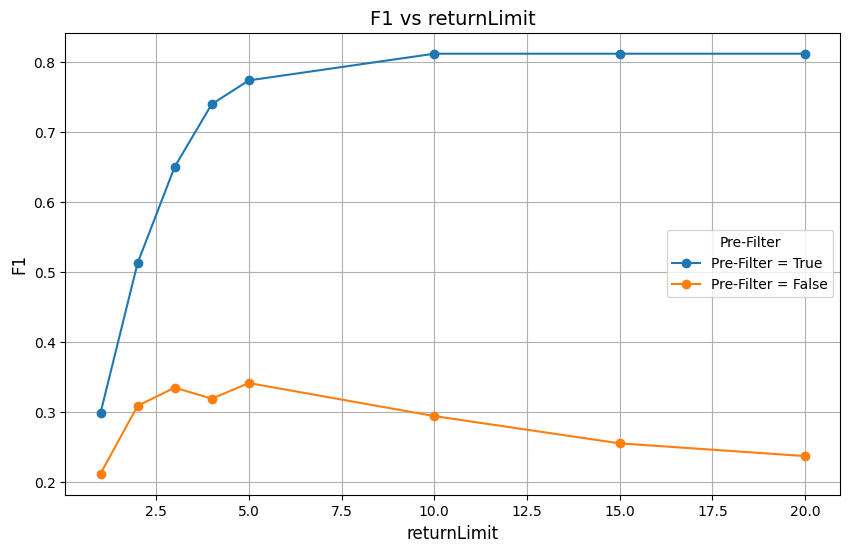

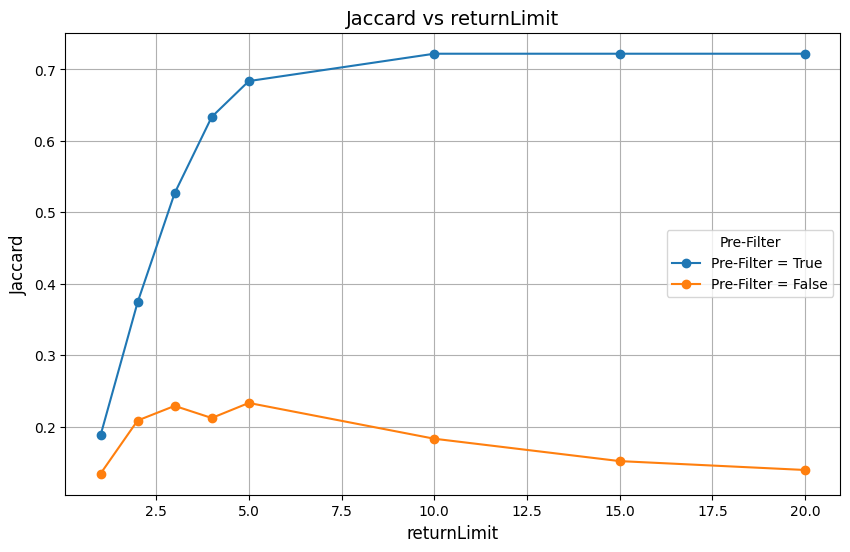

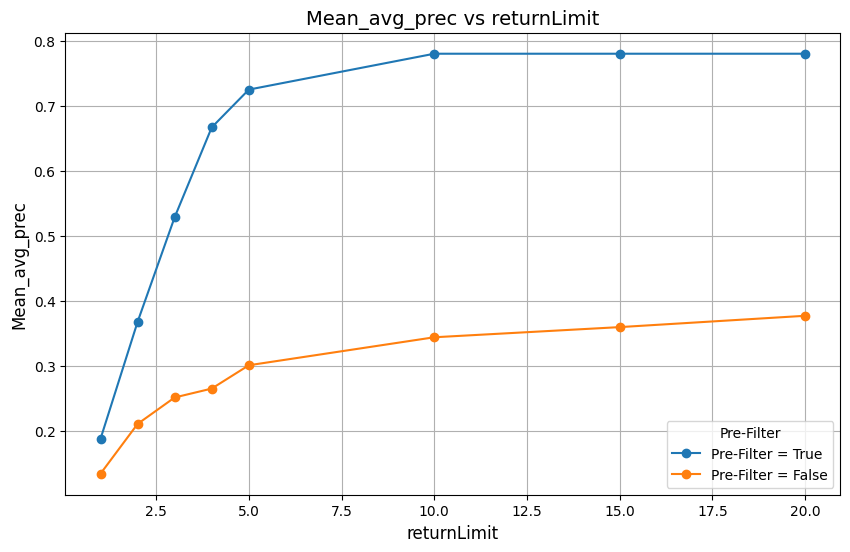

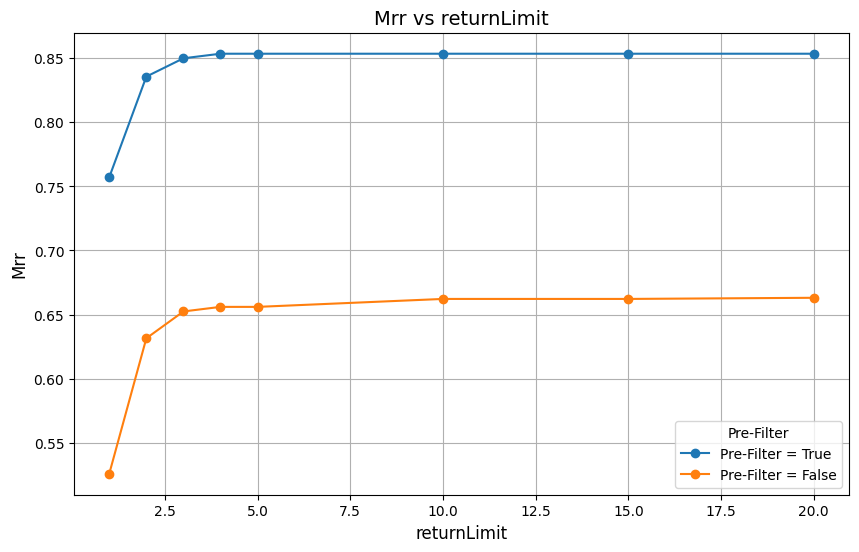

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'subjects' is a list of unique subjects in your DataFrame
subjects = results_df['subject'].unique()

results_df['returnLimit'] = pd.to_numeric(results_df['returnLimit'])

# Get all unique returnLimit values and sort them
returnLimit_values = sorted(results_df['returnLimit'].unique())

# Plot line graphs for every evaluation metric, with two lines per metric comparing mql values
metrics_list = ['precision', 'recall', 'f1', 'jaccard', 'mean_avg_prec', 'mrr']

for metric in metrics_list:
    plt.figure(figsize=(10, 6))
    
    # Loop over mql values
    for mql_value in [True, False]:
        # Filter data for the current mql value
        data_mql = results_df[results_df['mql'] == mql_value]
        
        # Group data by 'returnLimit' and compute mean of the metric
        data_grouped = data_mql.groupby('returnLimit')[metric].mean().reset_index()
        
        # Sort values by 'returnLimit'
        data_grouped = data_grouped.sort_values(by='returnLimit')
        
        # Plot the line for the current mql value
        plt.plot(
            data_grouped['returnLimit'],
            data_grouped[metric],
            marker='o',
            label=f"Pre-Filter = {mql_value}"
        )
    
    # Add titles and labels
    plt.title(f'{metric.capitalize()} vs returnLimit', fontsize=14)
    plt.xlabel('returnLimit', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title="Pre-Filter", fontsize=10)
    plt.grid(True)
    
    # Save the plot
    plt.savefig(f'evaluation_plots/ALLDATA_by_mql_returnLimit_{metric}.png')
    plt.show()


# Findings:

The numCandidates parameter did not affect retrieval eval metrics, hence we only varied the returnLimit parameter.

Pre-Filter is definitely the option to go, with optimal returnLimit set at 10.